# **Named Entity Recognition using LSTM and Keras**





# **1. Import Modules**

In [2]:
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)
plt.style.use('ggplot')
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
print('TensorFlow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.3.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from google.colab import files
uploaded = files.upload()

Saving ner_dataset.csv to ner_dataset.csv


# **2. Loading Dataset**

In [5]:
ner_data = pd.read_csv('ner_dataset.csv', encoding ='latin1')
ner_data = ner_data.fillna(method = 'ffill')
ner_data.head(25)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [6]:
print('Unique words in the NER dataset:', ner_data['Word'].nunique())
print("Unique tags in the NER dataset:", ner_data['Tag'].nunique())

Unique words in the NER dataset: 35178
Unique tags in the NER dataset: 17


In [7]:
words = list(set(ner_data['Word'].values))
words.append('ENDPAD')
num_words = len(words)

In [8]:
tags = list(set(ner_data['Tag'].values))
num_tag = len(tags)

In [9]:
print('num of words:', num_words)
print('num of tags:', num_tag)

num of words: 35179
num of tags: 17


# **3. Retrieve Sentences, POS and tags**

In [10]:
class sentenceRetrieve(object):
  def __init__(self, ner_data):
    self.ner_data = ner_data
    agg = lambda s: [(w, p, t) for (w, p, t) in zip(s['Word'].values.tolist(),
                                                    s['POS'].values.tolist(),
                                                    s['Tag'].values.tolist())]
    self.grouped = self.ner_data.groupby('Sentence #').apply(agg)
    self.sentences = [s for s in self.grouped]

In [11]:
sen = sentenceRetrieve(ner_data)
sentences = sen.sentences
print('Sentence, POS and Tags in position 0 is:')
sentences[0]

Sentence, POS and Tags in position 0 is:


[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

# **4. Mappings between words and tags**

In [12]:
wordtonum = {w: i+1 for i, w in enumerate(words)}
tagtonum = {t: i for i, t in enumerate(tags)}

In [ ]:
wordtonum

{'aids': 1,
 'Hutu': 2,
 'torchbearer': 3,
 'Blears': 4,
 'Yielding': 5,
 'lithium': 6,
 'unnerve': 7,
 'Nasrallah': 8,
 'inward': 9,
 'towns': 10,
 'Hexogen': 11,
 'Randolph': 12,
 'Pleasure': 13,
 'Abdallah': 14,
 '17-Jan': 15,
 'trivial': 16,
 'Nikolay': 17,
 'cottage': 18,
 "Sh'ite": 19,
 'K-4': 20,
 'credit-card': 21,
 'connects': 22,
 'fifteen-year': 23,
 'Karpinski': 24,
 'arabic': 25,
 'executing': 26,
 'Bisphenol': 27,
 'tandem': 28,
 'Mindanao': 29,
 'Hollywood': 30,
 'respect': 31,
 'permanent': 32,
 'Financial': 33,
 'disseminating': 34,
 'shellfish': 35,
 'jurors': 36,
 '12-year-civil': 37,
 'whose': 38,
 'cult': 39,
 'Island': 40,
 'firebombing': 41,
 '102-member': 42,
 'Skopje': 43,
 'pneumonia': 44,
 'six-nation': 45,
 'ecosystem': 46,
 'patented': 47,
 'generals': 48,
 '23.25': 49,
 'sideline': 50,
 'waver': 51,
 'diamond': 52,
 'Brad': 53,
 'Serie': 54,
 'wartime': 55,
 '472': 56,
 'complicating': 57,
 'Tourists': 58,
 'dampened': 59,
 'Reconstruction': 60,
 'disrupts

In [ ]:
wordtonum['the']

4417

In [ ]:
tagtonum

{'B-art': 15,
 'B-eve': 5,
 'B-geo': 14,
 'B-gpe': 10,
 'B-nat': 8,
 'B-org': 16,
 'B-per': 0,
 'B-tim': 7,
 'I-art': 12,
 'I-eve': 4,
 'I-geo': 9,
 'I-gpe': 1,
 'I-nat': 3,
 'I-org': 11,
 'I-per': 13,
 'I-tim': 2,
 'O': 6}

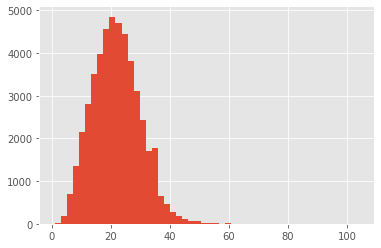

In [ ]:
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()

# **5. Creating feature map X and y for LSTM model**

In [13]:
max_len = 50 #maximum length of a sentence. 

X = [[wordtonum[w[0]] for w in s ] for s in sentences ] #for each sentence s and for each word in s get the index of that word from dictionary wordtonum
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value = num_words-1)

y = [[tagtonum[w[2]] for w in s ] for s in sentences ] # for each sentence s and for each tag in s get the index of that tag from dictionary tagtonum
y = pad_sequences(maxlen=max_len, sequences = y, padding = 'post', value = tagtonum['O'])
y = [to_categorical(i, num_classes = num_tag) for i in y]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (43163, 50)
X_test shape: (4796, 50)


# **6. Bidirectional LSTM**

In [15]:
input_sentence = Input(shape = max_len,)
model = Embedding(input_dim=num_words, output_dim = max_len, input_length = max_len)(input_sentence)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(units = num_tag, activation = 'softmax', ))(model)
model = Model(input_sentence, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 512)           628736    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            8721      
Total params: 2,396,407
Trainable params: 2,396,407
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' +string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' +string])
    plt.show()

# **7. Training Model**

In [19]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience=3, verbose=1, mode = 'max', restore_best_weights=True)
callbacks = [early_stopping]

history = model.fit(
    X_train, np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 5,
    verbose = 1, 
    callbacks = callbacks
)

Epoch 1/5
1080/1080 [==============================] - 342s 316ms/step - loss: 0.0256 - accuracy: 0.9917 - val_loss: 0.0480 - val_accuracy: 0.9861
Epoch 2/5
1080/1080 [==============================] - 339s 314ms/step - loss: 0.0220 - accuracy: 0.9928 - val_loss: 0.0488 - val_accuracy: 0.9858
Epoch 3/5
1080/1080 [==============================] - 341s 316ms/step - loss: 0.0194 - accuracy: 0.9936 - val_loss: 0.0531 - val_accuracy: 0.9859
Epoch 4/5
1080/1080 [==============================] - 345s 319ms/step - loss: 0.0170 - accuracy: 0.9943 - val_loss: 0.0547 - val_accuracy: 0.9858
Epoch 00004: early stopping


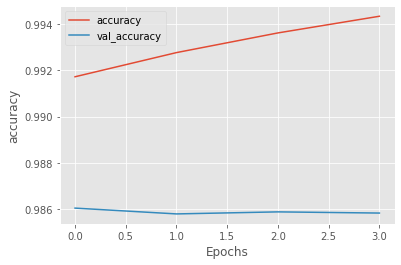

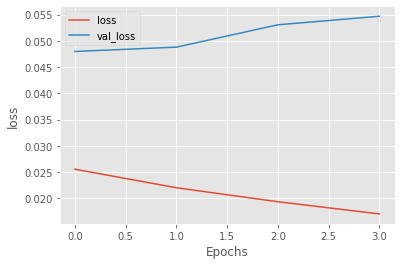

In [20]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# **8. Evaluating the model**

In [21]:
model.evaluate(X_test, np.array(y_test))


150/150 [==============================] - 4s 26ms/step - loss: 0.0514 - accuracy: 0.9853


[0.05143337696790695, 0.9852918982505798]

# **9. Displaying the results**

In [53]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print('{:15}{:5}\t{}\n'.format("Word", "True", "Pred"))
print('-'*30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
  print('{:15}{:5}\t{}'.format(words[w], tags[true], tags[pred]))

Word           True 	Pred

------------------------------
likes          B-per	B-per
Diamond        I-per	I-per
solidarity     O    	O
1911           O    	O
Alu            O    	O
disrespectful  O    	O
court-approved O    	O
Goldman-Sachs  O    	O
PLC            O    	O
Unlike         B-tim	B-tim
dictator       I-tim	I-tim
cooperative    O    	O
12-kilometer-highO    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDPAD         O    	O
ENDP